### Libraries



In [ ]:
# importing necessary libraries here
import numpy as np
import matplotlib.pyplot as plt

### Single Bandit problem

The bandit problem has $10$ arms. For each arm, the $q_{*}(a)$ value is  sampled from a Gaussian distribution with $0$ mean and unit variance . The rewards fro arm $a$ are sampled from a Gaussian distribution with mean $q_{}(a)$  and unit variance .


### Testbed

Generating 2000 different bandit problems. Using the sample average method with incremental implementation for learning the action values. Ploting the learning curves for 1000 timesteps with the following algorithms:

- gready
- $ϵ$-greedy
  - $ϵ$-0.1
  - $ϵ$-0.01

There are two learning curves for each algorithm:
- average reward vs time
- %  optimal actions vs time





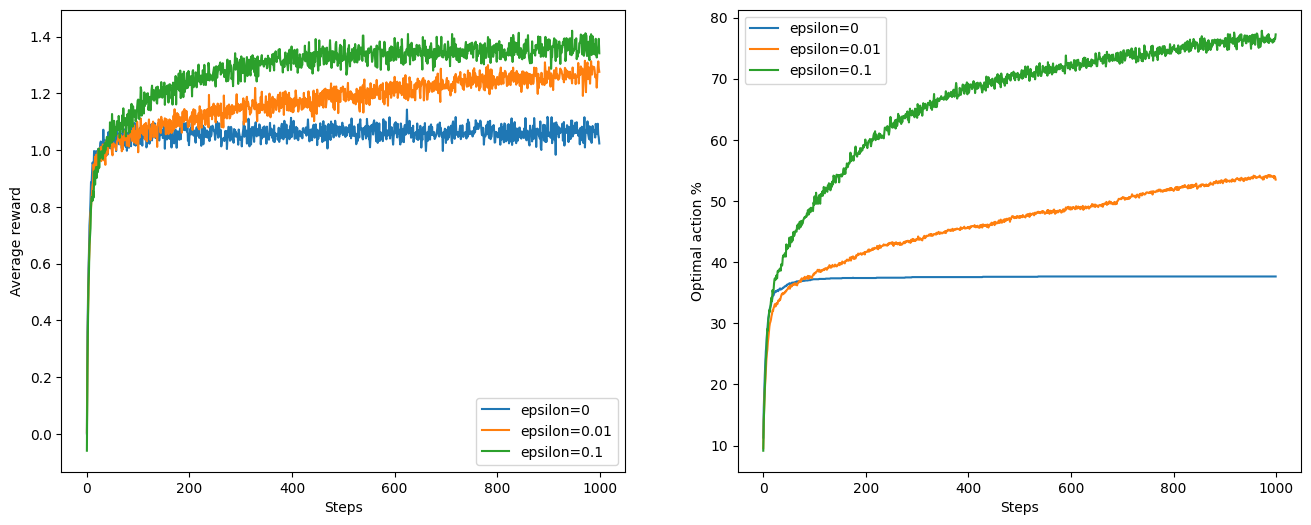

In [ ]:
def MAB(n, eps=0, steps=1000):
    # n: number of arms (actions)
    # eps: exploration factor (probability of selecting a random action)
    # steps: number of steps to run the multi-armed bandit algorithm

    expected_reward = np.random.normal(0, 1, size=n)  # True expected rewards for each action (mu*)
    estimated_reward = np.zeros(n)  # Estimated rewards for each action (Q(a))
    action_counts = np.zeros(n)  # Number of times each action has been chosen (k_i)
    alpha = np.zeros(n)  # Learning rates for each action
    res = np.zeros((steps, 2))  # Store the chosen action and received reward for each step

    for k in range(steps):
        # Exploration-exploitation trade-off
        if np.random.random() < eps:
            a = np.random.randint(n)  # Choose a random action
        else:
            a = np.argmax(estimated_reward)  # Choose the action with the highest estimated reward

        reward = np.random.normal(expected_reward[a])  # Simulate the reward for the chosen action
        res[k, :] = [a, reward]  # Store the chosen action and received reward

        action_counts[a] += 1  # Increment the count for the chosen action
        alpha[a] = 1 / (action_counts[a] + 1)  # Update the learning rate for the chosen action (alpha = 1/(k_i + 1))
        estimated_reward[a] += alpha[a] * (reward - estimated_reward[a])  # Update the estimated reward for the chosen action (Q(a_i) += alpha * (r_i - Q(a_i)))

    return res, expected_reward


def plotAvgRewardAndOptimalAction(problems, n, eps, steps):
    # problems: number of independent problems to run
    # n: number of arms (actions)
    # eps: exploration factor (probability of selecting a random action)
    # steps: number of steps to run the multi-armed bandit algorithm

    avg_rewards = np.zeros(steps)  # Average rewards over steps
    opt_actions = np.zeros(steps)  # Percentage of times optimal action is chosen over steps

    for i in range(problems):
        results, expected_reward = MAB(n, eps, steps)  # Run the multi-armed bandit algorithm

        avg_rewards += results[:, 1]  # Accumulate rewards for each step
        opt_idx = results[:, 0] == np.argmax(expected_reward)  # Find the steps where optimal action was chosen
        opt_actions[opt_idx] += 1  # Increment the count for optimal action being chosen

    avg_rewards /= problems  # Calculate the average rewards over independent problems
    opt_actions /= problems  # Calculate the percentage of times optimal action was chosen over independent problems

    avg_reward_plt.plot(avg_rewards, label="epsilon=" + str(eps))  # Plot average rewards
    opt_action_plt.plot(opt_actions * 100, label="epsilon=" + str(eps))  # Plot percentage of optimal actions

fig, (avg_reward_plt, opt_action_plt) = plt.subplots(1, 2, figsize=(16, 6))  # Create subplots for plotting

n = 10  # Number of arms (actions)
problems = 2000  # Number of independent problems to run
steps = 1000  # Number of steps to run the multi-armed bandit algorithm

for eps in [0, 0.01, 0.1]:  # Loop over different exploration factors
    plotAvgRewardAndOptimalAction(problems, n, eps, steps)  # Run the multi-armed bandit algorithm and plot results

avg_reward_plt.set_ylabel("Average reward")  # Set y-label for average reward plot
avg_reward_plt.set_xlabel("Steps")  # Set x-label for average reward plot
avg_reward_plt.legend()  # Add legend to average reward plot

opt_action_plt.set_ylabel("Optimal action %")  # Set y-label for optimal action plot
opt_action_plt.set_xlabel("Steps")  # Set x-label for optimal action plot
opt_action_plt.legend()  # Add legend to optimal action plot


### Observations

The graphs demonstrate the significance of maintaining a balance between exploration and exploitation. When we solely focus on exploiting the best known option without exploring other possibilities (epsilon = 0), the average rewards remain steady at 1. Moreover, the optimal action is selected only around 30% of the time. However, when we combine exploration with exploitation (epsilon = 0.1), the average rewards can increase up to 1.4, and the optimal action is chosen more frequently, approximately 80% of the time.

Running the UCB algorithm on the ten-armed testbed. Ploting the learning curve for UCB and comparing it with $\epsilon$-greedy for $\epsilon = 0.1$.

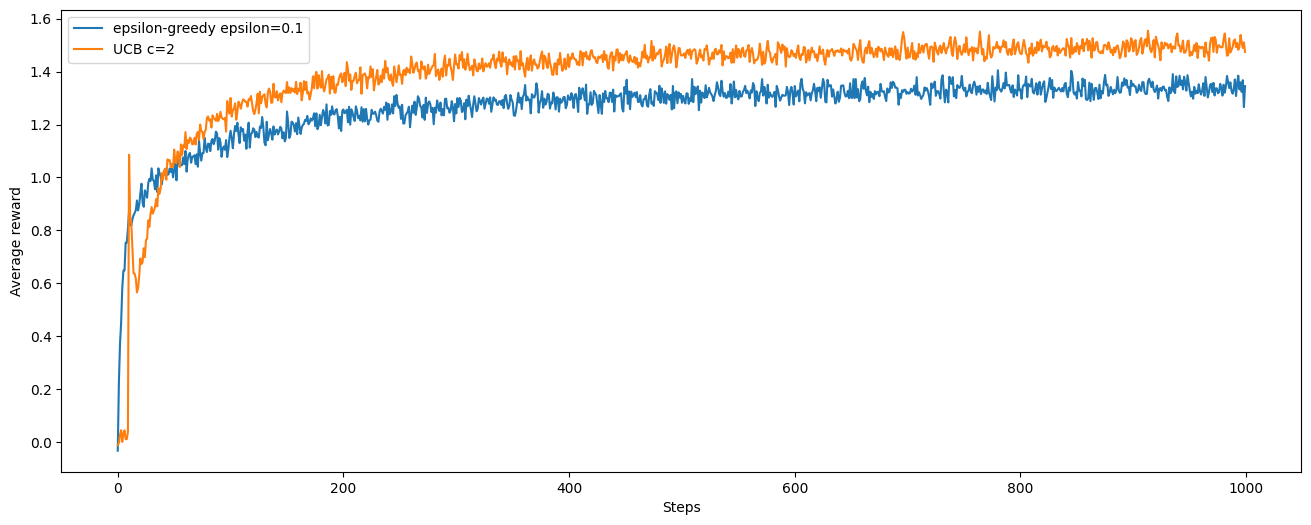

In [ ]:
def UCB(n, steps, c):
    # n: number of arms (actions)
    # c: exploration factor
    # steps: number of steps to run the multi-armed bandit algorithm

    expected_reward = np.random.normal(0, 1, size=n)  # True expected rewards for each action (mu*)
    estimated_reward = np.zeros(n)  # Estimated rewards for each action (Q(a))
    action_counts = np.zeros(n)  # Number of times each action has been chosen (k_i)
    alpha = np.zeros(n)  # Learning rates for each action
    res = np.zeros((steps, 2))  # Store the chosen action and received reward

    for k in range(steps):
        zero_idx = np.where(action_counts == 0)[0]
        if len(zero_idx) > 0:
            a = zero_idx[0]  # If any action hasn't been chosen yet, select the first available action
        else:
            # Use the Upper Confidence Bound (UCB) formula to select the action with the highest upper bound
            a = np.argmax(estimated_reward + c * np.sqrt(np.log(k + 1) / action_counts))

        reward = np.random.normal(expected_reward[a])  # Simulate the reward for the chosen action
        res[k, :] = [a, reward]  # Store the chosen action and received reward

        action_counts[a] += 1  # Increment the count for the chosen action
        alpha[a] = 1 / (action_counts[a] + 1)  # Update the learning rate for the chosen action (alpha = 1/(k_i + 1))
        estimated_reward[a] += alpha[a] * (reward - estimated_reward[a])  # Update the estimated reward for the chosen action (Q(a_i) += alpha * (r_i - Q(a_i)))

    return res


def plotAvgReward(problems, n, eps, c, steps, is_UCB):
    # problems: number of independent problems to run
    # n: number of arms (actions)
    # eps: exploration factor (probability of selecting a random action)
    # c: exploration parameter for UCB
    # steps: number of steps to run the multi-armed bandit algorithm
    # is_UCB: boolean flag to indicate if UCB algorithm should be used

    avg_rewards = np.zeros(steps)  # Average rewards over steps

    for i in range(problems):
        if not is_UCB:
            results, expected_reward = MAB(n, eps, steps)  # Run the epsilon-greedy multi-armed bandit algorithm
        else:
            results = UCB(n, steps, c)  # Run the UCB multi-armed bandit algorithm
        avg_rewards += results[:, 1]  # Accumulate rewards for each step

    avg_rewards /= problems  # Calculate the average rewards over independent problems
    if not is_UCB:
        avg_reward_plt.plot(avg_rewards, label="epsilon-greedy epsilon=" + str(eps))  # Plot average rewards for epsilon-greedy
    else:
        avg_reward_plt.plot(avg_rewards, label="UCB c=" + str(c))  # Plot average rewards for UCB

fig, avg_reward_plt = plt.subplots(1, 1, figsize=(16, 6))  # Create subplot for plotting

n = 10  # Number of arms (actions)
problems = 2000  # Number of independent problems to run
steps = 1000  # Number of steps to run the multi-armed bandit algorithm
eps = 0.1  # Exploration factor for epsilon-greedy
c = 2  # Exploration parameter for UCB

plotAvgReward(problems, n, eps, c, steps, is_UCB=False)  # Plot average rewards for epsilon-greedy
plotAvgReward(problems, n, eps, c, steps, is_UCB=True)  # Plot average rewards for UCB

avg_reward_plt.set_ylabel("Average reward")  # Set y-label for average reward plot
avg_reward_plt.set_xlabel("Steps")  # Set x-label for average reward plot
avg_reward_plt.legend()  # Add legend to average reward plot


### Observations
Based on the graph, it can be observed that the disparity between the average rewards obtained from the UCB and epsilon-greedy algorithms is not substantial. However, there is a slight advantage in performance for the UCB algorithm compared to the epsilon-greedy algorithm.




Solving the previous problems for $10,000$ arms.

(0.0, 1.0)

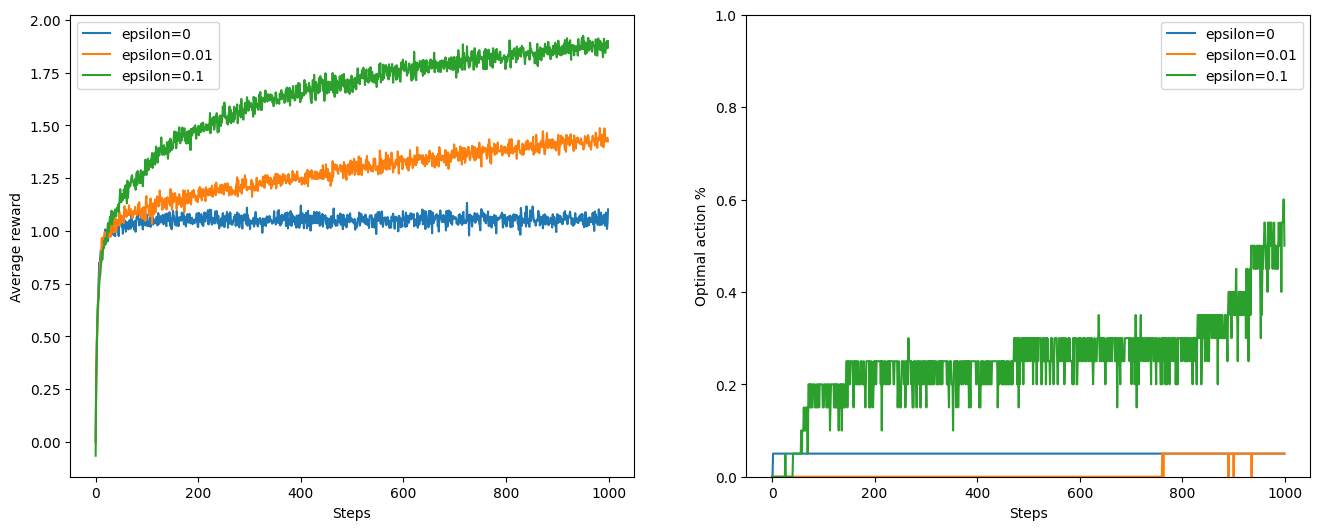

In [ ]:
fig, (avg_reward_plt, opt_action_plt) = plt.subplots(1, 2, figsize=(16, 6))  # Create subplots for plotting

n = 10000  # Number of arms (actions)
problems = 2000  # Number of independent problems to run
steps = 1000  # Number of steps to run the multi-armed bandit algorithm

for eps in [0, 0.01, 0.1]:  # Loop over different exploration factors
    plotAvgRewardAndOptimalAction(problems, n, eps, steps)  # Run the multi-armed bandit algorithm and plot results

avg_reward_plt.set_ylabel("Average reward")  # Set y-label for average reward plot
avg_reward_plt.set_xlabel("Steps")  # Set x-label for average reward plot
avg_reward_plt.legend()  # Add legend to average reward plot

opt_action_plt.set_ylabel("Optimal action %")  # Set y-label for optimal action plot
opt_action_plt.set_xlabel("Steps")  # Set x-label for optimal action plot
opt_action_plt.legend()  # Add legend to optimal action plot
opt_action_plt.set_ylim([0, 1])

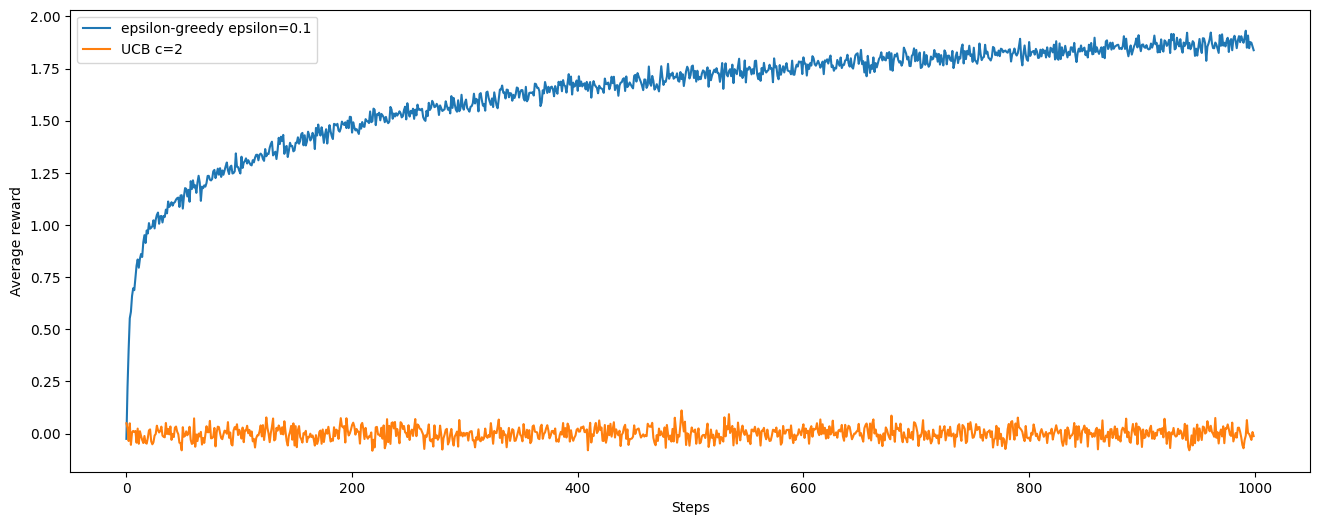

In [ ]:
fig, avg_reward_plt = plt.subplots(1, 1, figsize=(16, 6))  # Create subplot for plotting

n = 10000  # Number of arms (actions)
problems = 2000  # Number of independent problems to run
steps = 1000  # Number of steps to run the multi-armed bandit algorithm
eps = 0.1  # Exploration factor for epsilon-greedy
c = 2  # Exploration parameter for UCB

plotAvgReward(problems, n, eps, c, steps, is_UCB=False)  # Plot average rewards for epsilon-greedy
plotAvgReward(problems, n, eps, c, steps, is_UCB=True)  # Plot average rewards for UCB

avg_reward_plt.set_ylabel("Average reward")  # Set y-label for average reward plot
avg_reward_plt.set_xlabel("Steps")  # Set x-label for average reward plot
avg_reward_plt.legend()  # Add legend to average reward plot


### Observations

After conducting the epsilon-greedy algorithm with varying values of epsilon, interesting observations have emerged. Firstly, when comparing the average return plots for 10,000 arms and 10 arms, they appear remarkably similar. This suggests that the number of arms does not significantly impact the average return obtained. Furthermore, the results demonstrate that an epsilon value of 0.1 leads to the highest average reward, reaching around 2, while an epsilon value of 0 yields the lowest average reward, remaining constant at 1. This indicates that a higher level of exploration (epsilon = 0.1) results in a more favorable overall reward outcome. However, the plot depicting the percentage of optimal actions chosen reveals a peculiar behavior. The epsilon-greedy algorithm with epsilon = 0 rarely selects an optimal action, indicating a lack of exploration. Conversely, even with epsilon = 0.1, the probability of choosing the optimal action remains notably low at 0.7%. This implies that epsilon-greedy struggles to consistently identify and select the optimal action, regardless of the exploration factor employed.

The comparison graph between epsilon-greedy and UCB algorithms also showcases bizarre results. The average returns for the epsilon-greedy algorithm with epsilon = 0.1 closely align with the previous plot, reaching a maximum of 2. However, the average returns for the UCB algorithm persistently remain at 0. This discrepancy arises because the UCB algorithm typically samples each arm once before proceeding with the main algorithm.


